In [1]:
# Import Statements
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np
import pygame
from pygame.locals import *
import matplotlib.pyplot as plt
from Common_functions import file_io, pygame_visuals as pv
from random import randint

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#RL Agent

class func_sarsa():
    """
    Uses True Online SARSA(lambda) or a standard SARSA(lambda) to learn. (This can be controlled by using either update func) 
    States are represented with with natural numbers. Same for actions.
    
    Game Loop should look like:
    Get first action (baction, bstate)
    Repeat until terminal state
      take the action   (reward)
      update env (nstate)
      get action    (naction)
      update agent (bstate, baction <-- nstate, naction)
    """
    
    def __init__(self, gamma, alpha, epsilon, min_epsilon, lamda, num_features, num_actions):
        """
        Initalizes agent. 
        
        Params: 
        gamma:       disount factor. How much it cares about the future. [0,1]
        alpha:       step size rate. How much it updates current prediction towards new one. [0,1]
        epsilon:     exploration rate. How often it makes random moves. [0,1]
        min_epsilon: lower bound on epsilon. [0,1]
        lamda:       weight of n-step return. [0,1]
        ...
        """
        #Learning parameters
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.lamda = lamda
        
        #Field variables
        self.weights = np.ones(num_features)
        self.not_min_epsilon = True
        self.num_features = num_features
        self.num_actions = num_actions
        
        #Resetable 
        self.bfeature = None
        self.bval = None
        self.eligibility = np.zeros(num_features)
        
    def reset(self):
        self.bfeature = None
        self.bvalue = None
        self.eligibility = np.zeros(self.num_features)
        
    def set_init_values(self, feature):
        self.bfeature = feature
        self.bval = self.q_value(feature)
    
    def q_value(self, feature_vector):
        return np.dot(self.weights, feature_vector)
    
    def choose_action(self, feature_list, debug = False):
        """
        Returns action given state. Both are represented as whole numbers
        
        Params:
        state:   whole number corresponding to state
        """
        if debug: #####
            print("------------------------------------------------------------------")
            print("in choose_action")
            print("feature_list", feature_list)
            print("self.epsilon", self.epsilon)
            
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0,self.num_actions)
            if debug: #####
                print("chosen random action: ", action)
                print("------------------------------------------------------------------")
            return action
        else:
            action_values = [self.q_value(feature) for feature in feature_list]
            if debug: #####
                print("chosen max value action")
                print("action_values", action_values)
                print("------------------------------------------------------------------")
            return  action_values.index(max(action_values))
            
        
    def silver_update(self, feature, reward, debug = False):
        
        if debug: #####
            print("New update")
            print("reward", reward)
            print('weights',  self.weights)
            print('feature', feature)
            print('bfeature', self.bfeature)
        
        sarsa_error = reward + self.gamma * np.dot(feature, self.weights) - np.dot(self.bfeature, self.weights)
        
        if debug: #####
            print('sarsa error', sarsa_error)
            print('before eligibility', self.eligibility)
            
        self.eligibility = self.gamma*self.lamda*self.eligibility + self.bfeature
        
        if debug: #####
            print('after eligibility', self.eligibility)
            print('before weights', self.weights)
            
        self.weights += self.alpha*sarsa_error*self.eligibility
        
        if debug: #####
            print('after weights', self.weights)
        
        self.bfeature = feature
            
        if self.not_min_epsilon: 
            self.epsilon *= 0.999999
            if self.epsilon <= 0.1:
                self.not_min_epsilon = False
        
    def true_update(self, feature, reward, debug = False):
        
        val = self.q_value(feature)
        
        if debug: #####
            print("New update")
            print("reward", self.reward)
            print('weights',  self.weights)
            print('feature', feature)
            print('bval', self.bval)
            print('val', val)
        
        sarsa_error = reward + self.gamma * val - self.bval        
        
        if debug: #####
            print('sarsa error', sarsa_error)
            print('before eligibility', self.eligibility)
        
        add_on = self.alpha*(1 - self.gamma*self.lamda * np.dot(self.eligibility, self.bfeature)) * self.bfeature
        self.eligibility = self.gamma*self.lamda *self.eligibility + add_on
        
        if debug: #####
            print('add on eligibility', add_on)
            print('after eligibility', self.eligibility)
            print('before weights', self.weights)


        
        add_on = self.alpha*(self.bval - np.dot(self.weights, self.bfeature))*self.bfeature
        self.weights = self.weights + sarsa_error*self.eligibility + add_on
           
        if debug: #####
            print('add on weights', add_on, "\n")
            print('after weights', self.weights)

            
        self.bval = val
        self.bfeature = feature
            
        if self.not_min_epsilon: 
            self.epsilon *= 0.9999999
            if self.epsilon <= 0.1:
                self.not_min_epsilon = False
                
               
    
    def save(self, filename = 'agent_func.txt'):
        
        with open(filename, mode = 'w') as file:
            file.write(str(self.gamma) + " " + str(self.alpha) + " " + str(self.epsilon) + " " + str(self.min_epsilon) + " ")
            file.write(str(self.lamda) + " " + str(self.not_min_epsilon) + " " + str(self.num_features) + " " + str(self.num_actions))
            file.write("\n\n" + str(self.weights))
            
    def load(self, filename = 'agent_func.txt'):
        filename = filename
        
        with open(filename, mode = 'r') as file:
            sarsa_string = file.read()
            params, weights = sarsa_string.split("\n\n")
            params_list = params.split(" ")
            
            self.gamma, self.alpha, self.epsilon, self.min_epsilon, self.lamda = [float(val) for val in params_list[:5]]
            self.not_min_epsilon = bool(params_list[5])
            self.num_features, self.num_actions = [int(params_list[k]) for k in [6,7]]

            
            self.weights = np.array(file_io.from_onedim_nparr(weights))
            self.reset()

In [3]:
#Environment

class snake:
    
    def __init__(self, cs, num_xblocks, num_yblocks):
        
        self.cs = cs
        self.xblocks  = num_xblocks
        self.yblocks = num_yblocks
        self.xend = (1+num_xblocks)*self.cs
        self.yend = (1+num_yblocks)*self.cs
        
        self.body_init = (int(num_xblocks/3)*cs, cs + int(num_yblocks/2)*cs)
        
        # Body order: [tail, middle,..., front]
        self.body = [pygame.Rect(self.body_init, (cs, cs))]
        
        self.move = [cs,0]
        self.init_moves_left = num_xblocks + num_yblocks
        self.moves_left = self.init_moves_left
        
    def draw(self, gameDisplay):
        for rect in self.body:
            pygame.draw.rect(gameDisplay, (0,255,0), rect)
            
        for i in range(self.cs, self.xend+1, self.cs):
            pygame.draw.line(gameDisplay, (255,255,255), (i, self.cs), (i, self.yend))
            
        for i in range(self.cs, self.yend+1, self.cs):        
            pygame.draw.line(gameDisplay, (255,255,255), (self.cs, i), (self.xend, i))
        
    
    def reset(self):
        self.body = [pygame.Rect(self.body_init, (self.cs, self.cs))]
        self.move = [self.cs,0]
        self.moves_left = self.init_moves_left
    
    def set_movement(self, action):
        
        if action == 0:
            potential = [self.cs, 0]
        elif action == 1:
            potential = [0,self.cs]
        elif action == 2:
            potential = [-self.cs,0]
        elif action == 3:
            potential = [0,-self.cs]
        
        if not (potential[0] != 0 and (potential[0] == -1*self.move[0])):
            if not (potential[1] != 0 and (potential[1] == -1*self.move[1])):
                
                self.move = potential 
    
    def update(self, apple_rect, action):
        
        if self.moves_left <= 0:
            return 'moves done'
        
        self.moves_left -= 1
        
        self.set_movement(action)
        test_rect = pygame.Rect(self.body[-1].left + self.move[0], self.body[-1].top + self.move[1], self.cs, self.cs)
                    
        if test_rect.colliderect(apple_rect):
            self.body.append(test_rect)
            self.moves_left += self.init_moves_left
            return 'apple'
            
            
        elif self.check_boundary(test_rect):
            return 'boundary'
        else:    
            if len(self.body) >= 4:
                for rect in self.body[2:]:
                    if test_rect.colliderect(rect):
                        return 'collision'
                        
            self.body.pop(0) 
            self.body.append(test_rect)
            return 'normal'
    
    def check_boundary(self, rect):
        return rect.left >= self.xend or rect.left < self.cs or rect.top >= self.yend or rect.top < self.cs
    
        
class apple:
    
    def __init__(self, cs, num_xblocks, num_yblocks):
        self.body_init = (2*int(num_xblocks/3)*cs, cs + int(num_yblocks/2)*cs, cs, cs)
        self.body = pygame.Rect(self.body_init)
        self.all_positions = [pygame.Rect(cs*x,cs*y,cs,cs) for x in range(1, num_xblocks+1) for y in range(1, num_yblocks+1)]
    
    def reset(self):
        self.body = pygame.Rect(self.body_init)
        
    def respawn(self, snake_body):
        all_squares = list(self.all_positions)
        for rect in snake_body:
            try:
                all_squares.pop(all_squares.index(rect))
            except:
                pass
        self.body = all_squares[randint(0, len(all_squares)-1)]
    
    def draw(self, gameDisplay):
        pygame.draw.rect(gameDisplay, (255,0,0), self.body)
    
class game:
    
    def __init__(self, cs, num_xblocks, num_yblocks, vision):
        
        self.terminal = False
        self.reward = 0
        self.score = 0
        
        self.player = snake(cs, num_xblocks, num_yblocks)
        self.food = apple(cs, num_xblocks, num_yblocks)
        
        self.cs = cs
        self.vision = vision
        self.feature_size = vision**2+2
        self.shift = int(vision/2)
    
    def update(self, action):
        
        result = self.player.update(self.food.body, action)
        
        if result == 'apple':
            self.reward = 40
            self.food.respawn(self.player.body)
            
        elif result == 'boundary':
            self.reward = -10
            self.terminal = True
            
        elif result == 'collision':
            self.reward = -10
            self.terminal = True
        
        elif result == 'moves done':
            self.reward = -18
            self.terminal = True
            
        elif result == 'normal':
            self.reward = -1
            
        self.score += self.reward
    
    def reset(self):
        self.player.reset()
        self.food.reset()
        
        self.terminal = False
        self.reward = 0
        self.score = 0
    
    def return_feature(self, action):
        feature = np.zeros(self.feature_size)
                
        original_move = self.player.move.copy()

        self.player.set_movement(action)
        move_flag = 0 # 0 is normal, 1 is collision, 2 is apple
        
        topleft_xpos = self.player.body[-1].left + self.player.move[0]
        topleft_ypos = self.player.body[-1].top + self.player.move[1]
        
        test_rect = pygame.Rect(topleft_xpos, topleft_ypos, self.cs, self.cs)
        
        if self.player.check_boundary(test_rect):
            topleft_xpos -= self.player.move[0]
            topleft_ypos -= self.player.move[1]
            move_flag = 1
           
        elif test_rect.colliderect(self.food.body):
            move_flag = 2
        else:
            if len(self.player.body) >= 4:
                for rect in self.player.body[2:]:
                    if test_rect.colliderect(rect):
                        move_flag = 1
                        topleft_xpos -= self.player.move[0]
                        topleft_ypos -= self.player.move[1]
                        break
        
        feature[0], feature[1] = (topleft_xpos - self.food.body.left)//self.cs, (topleft_ypos - self.food.body.top)//self.cs
        
        if move_flag == 0:
            check_list = self.player.body[1:].copy()
            check_list.append(pygame.Rect(test_rect))
        elif move_flag == 1:
            check_list = self.player.body.copy()
        elif move_flag == 2:
            check_list = self.player.body.copy()
            check_list.append(test_rect)
        
        topleft_xpos -= self.shift*self.cs
        topleft_ypos -= self.shift*self.cs
        
        for i in range(self.vision):
            for j in range(self.vision):
                rect = pygame.Rect(topleft_xpos+i*self.cs, topleft_ypos+j*self.cs, self.cs, self.cs)
                
                if self.player.check_boundary(rect):
                    feature[2+i+self.vision*j] = 1
                else:                
                    for check_rect in check_list:
                        if check_rect.colliderect(rect):
                            feature[2+i+self.vision*j] = 1
                            break
        
        self.player.move = original_move
        return feature
    
    def return_all_features(self):
        return [self.return_feature(action) for action in range(4)]
    
    def draw(self, gameDisplay):
        self.food.draw(gameDisplay)
        self.player.draw(gameDisplay)
        pv.show_text(gameDisplay, 'Score: '+ str(self.score), topleft = (self.player.xend+10, self.player.cs), text_color = (0,255,0), priority = 0)
        pv.show_text(gameDisplay, 'Moves left: '+ str(self.player.moves_left), topleft = (self.player.xend+10, 2*self.player.cs), text_color = (0,255,0), priority = 0)

In [7]:
# Vision specifies how much the agent can see. As an input the agent recieves the xdist and ydist to the apple and it also
# recieves binary inputs. Those inputs are calculated as follows: First a vision by vision grid is formed with the center 
# being the snake's head. Then squares are set to 1 if whatever is in the square can kill the snake (boundaries included)
# otherwise they are 0. By putting all those together this forms all the inputs to linear function approximator


vision = 5
env = game(20,12,12, vision)

In [6]:
step_data = []
score_data = []

In [7]:
label = 'vision ' + str(vision) + ' agent'

agent_save = label + '.txt'

agent = func_sarsa(0.8,0.01,1,0.1,1.0,vision**2+2,4)

num_training_episodes = 1000

episodes_vs_steps = []
episodes_vs_score = []
 
agent.reset()
env.reset()

for i in range(1, num_training_episodes+1):
    
    if (i*100%num_training_episodes) == 0:
        print("Epsiodes done: ", i)
        
    #Actual Training Logic
    all_features = env.return_all_features()
    action = agent.choose_action(all_features)
    
    init_feature = all_features[action]
    agent.set_init_values(init_feature)
    
    steps = 0
    while not env.terminal:
        env.update(action)
        reward = env.reward
        
        all_features = env.return_all_features()
        action = agent.choose_action(all_features)
        agent.silver_update(all_features[action], reward)
        
        steps+=1

    episodes_vs_steps.append((i+1, steps))
    episodes_vs_score.append((i+1, env.score))

    env.reset()    
    agent.reset()
    
step_data.append([episodes_vs_steps, label])
score_data.append([episodes_vs_score, label])
    
agent.save(filename = agent_save)

Epsiodes done:  10
Epsiodes done:  20
Epsiodes done:  30
Epsiodes done:  40
Epsiodes done:  50
Epsiodes done:  60
Epsiodes done:  70
Epsiodes done:  80
Epsiodes done:  90
Epsiodes done:  100
Epsiodes done:  110
Epsiodes done:  120
Epsiodes done:  130
Epsiodes done:  140
Epsiodes done:  150
Epsiodes done:  160
Epsiodes done:  170
Epsiodes done:  180
Epsiodes done:  190
Epsiodes done:  200
Epsiodes done:  210
Epsiodes done:  220
Epsiodes done:  230
Epsiodes done:  240
Epsiodes done:  250
Epsiodes done:  260
Epsiodes done:  270
Epsiodes done:  280
Epsiodes done:  290
Epsiodes done:  300
Epsiodes done:  310
Epsiodes done:  320
Epsiodes done:  330
Epsiodes done:  340
Epsiodes done:  350
Epsiodes done:  360
Epsiodes done:  370
Epsiodes done:  380
Epsiodes done:  390
Epsiodes done:  400
Epsiodes done:  410
Epsiodes done:  420
Epsiodes done:  430
Epsiodes done:  440
Epsiodes done:  450
Epsiodes done:  460
Epsiodes done:  470
Epsiodes done:  480
Epsiodes done:  490
Epsiodes done:  500
Epsiodes 

In [8]:
# If you don't have enough time to fully train the agent you can interrupt the cell above and then run this 

step_data.append([episodes_vs_steps, label])
score_data.append([episodes_vs_score, label])
    
agent.save(filename = agent_save)

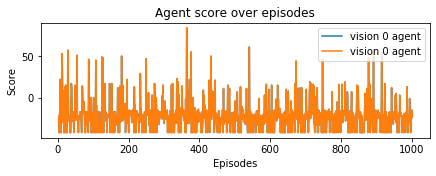

In [9]:
# graph the score over episodes

fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])


for info_score_package in score_data:
    episodes, score = zip(*info_score_package[0])
    axes.plot(episodes, score, label = info_score_package[1])
    
axes.set_xlabel('Episodes')
axes.set_ylabel('Score')
axes.set_title("Agent score over episodes")
axes.legend(loc=0)

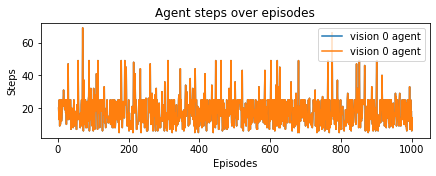

In [10]:
# graph the steps over episodes

fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])


for info_steps_package in step_data:
    episodes, score = zip(*info_steps_package[0])
    axes.plot(episodes, score, label = info_steps_package[1])
    
axes.set_xlabel('Episodes')
axes.set_ylabel('Steps')
axes.set_title("Agent steps over episodes")
axes.legend(loc=0)

In [12]:
#View the current agent


pygame.init()
pygame.display.set_caption('Gridworld Viewer')
gameDisplay = pygame.display.set_mode((600,400))

agent = func_sarsa(1,1,1,1,1,1,1)
env = game(20,12,12, 5)

agent.load(filename = 'vision 5 agent.txt')
orig_epsilon = agent.epsilon
agent.epsilon = 0
env.reset()
agent.reset()

all_features = env.return_all_features()
action = agent.choose_action(all_features)
    
init_feature = all_features[action]
agent.set_init_values(init_feature)


run = True
paused = False
while run:

    # Human interaction
    for event in pygame.event.get():
        if event.type == QUIT:
            run = False
            
        elif event.type == KEYDOWN:
            if event.key == pygame.K_SPACE:
                run = False
            elif event.key == pygame.K_p:
                if paused:
                    paused = False
                else: 
                    paused = True
                    
    if paused:
        pygame.time.wait(250)
        continue
           

    #Game Logic
    env.update(action)
    reward = env.reward
        
    all_features = env.return_all_features()
    action = agent.choose_action(all_features)
    #agent.silver_update(all_features[action], reward, debug = True)

    if env.terminal:
            
        env.reset()
        agent.reset()
        all_features = env.return_all_features()
        action = agent.choose_action(all_features)
    
        init_feature = all_features[action]
        agent.set_init_values(init_feature)
        
        gameDisplay.fill((0,0,0))
        pv.show_text(gameDisplay, "Done", topleft = (200,200))
        pygame.display.update()
        pygame.time.wait(200)

    #Visuals
    gameDisplay.fill((0,0,0))
    env.draw(gameDisplay)
    pygame.display.update()

    pygame.time.wait(150)

pygame.quit()

agent.epsilon = orig_epsilon

In [9]:
pygame.quit()

In [21]:
agent.weights

array([2.69220431, 0.5201796 ])

In [24]:
env.player.body

[<rect(160, 140, 20, 20)>, <rect(180, 140, 20, 20)>]

In [25]:
env.food.body

<rect(160, 240, 20, 20)>

In [27]:
env.return_all_features()

[array([ 2., -5.]), array([ 1., -4.]), array([ 2., -5.]), array([ 1., -6.])]